### 지연된 MLP를 사용한 CMAPSS 를 통한 RUL 예측

이번 파일에서는 FD002를 다룰 것이다. FD002는 작동 조건이 6가지로, FD001,FD003보다 어려운 데이터셋이다.
고장 조건은 HPC Degradation으로 한 개이다.

In [1]:
# 데이터 로드
%matplotlib inline
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
dir_path = '../CMAPSSData/'
train_file = 'train_FD002.txt'
test_file = 'test_FD002.txt'
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
train = pd.read_csv((dir_path+train_file), sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv((dir_path+test_file), sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD002.txt'), sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

print(train.shape)
train.head()

(53759, 26)


unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0        1            1    34.9983     0.8400      100.0  449.44  555.32   
1        1            2    41.9982     0.8408      100.0  445.00  549.90   
2        1            3    24.9988     0.6218       60.0  462.54  537.31   
3        1            4    42.0077     0.8416      100.0  445.00  549.51   
4        1            5    25.0005     0.6203       60.0  462.54  537.07   

       s_3      s_4   s_5  ...    s_12     s_13     s_14     s_15  s_16  s_17  \
0  1358.61  1137.23  5.48  ...  183.06  2387.72  8048.56   9.3461  0.02   334   
1  1353.22  1125.78  3.91  ...  130.42  2387.66  8072.30   9.3774  0.02   330   
2  1256.76  1047.45  7.05  ...  164.22  2028.03  7864.87  10.8941  0.02   309   
3  1354.03  1126.38  3.91  ...  130.72  2387.61  8068.66   9.3528  0.02   329   
4  1257.71  1047.93  7.05  ...  164.31  2028.00  7861.23  10.8963  0.02   309   

   s_18    s_19   s_20    s_21  
0  2223  100.00  14.73  8.8071  
1  2212  100.00  10.41  6.2665  
2  1915   84.93  14.08  8.6723  
3  2212  100.00  10.59  6.4701  
4  1915   84.93  14.13  8.5286  

[5 rows x 26 columns]

In [3]:

def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

unit_nr  time_cycles  RUL
0        1            1  148
1        1            2  147
2        1            3  146
3        1            4  145
4        1            5  144

FD002는 작동조건이 6가지이므로, 앞에 FD001,FD003과는 다르게  
setting_1,2,3에서 유의미한 변화가 발생한다.

여기서 작동조건 6가지는 setting_1,2,3의 조합에 따라 6가지 범위가 있다는 말인 것 같다.

In [4]:
# check unique combinations
settings_df = train[setting_names].copy()
settings_df['setting_1'] = settings_df['setting_1'].round()
settings_df['setting_2'] = settings_df['setting_2'].round(decimals=2)
settings_df.groupby(by=setting_names).size()
# setting_1,2,3을 조합하면 6가지 경우가 나온다.

# 0 0 100, 10 0.25 100, 20 0.7 100, 25 0.62 60 .. 이런 식으로 6가지가 있음.

setting_1  setting_2  setting_3
0.0        0.00       100.0         8044
10.0       0.25       100.0         8096
20.0       0.70       100.0         8122
25.0       0.62       60.0          8002
35.0       0.84       100.0         8037
42.0       0.84       100.0        13458
dtype: int64

그리고 시각화를 해보자.   
아래는 unit_nr 10의 RUL에 대한 s_2 값 그래프이다.

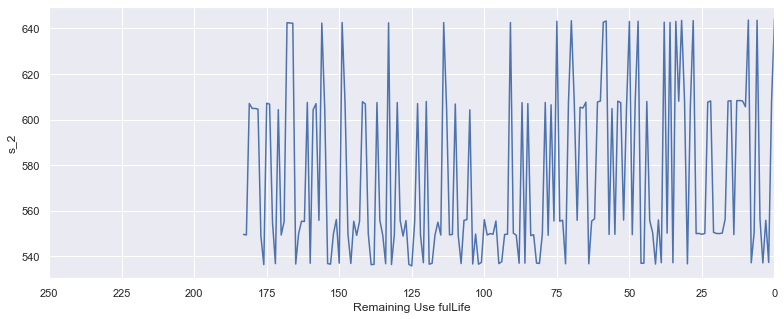

In [5]:

def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))
    
    if unit_nr:
        plt.plot('RUL', signal_name, 
                data=df[df['unit_nr']==unit_nr])
    else:
        for i in train['unit_nr'].unique():
            if (i % 10 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name, 
                         data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

# specifically plotting s_2, I'm using this as an example throughout the rest of the analysis  
plot_signal(train, 's_2', unit_nr=10)

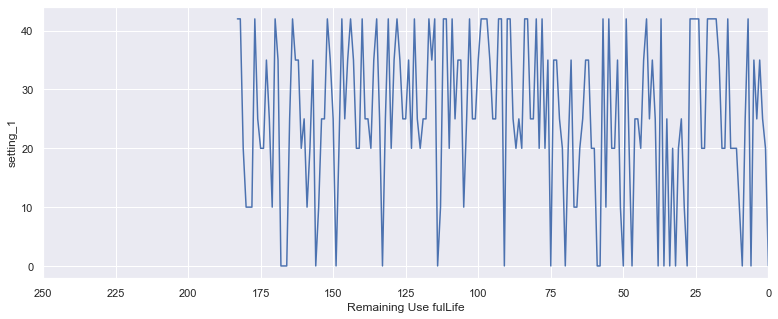

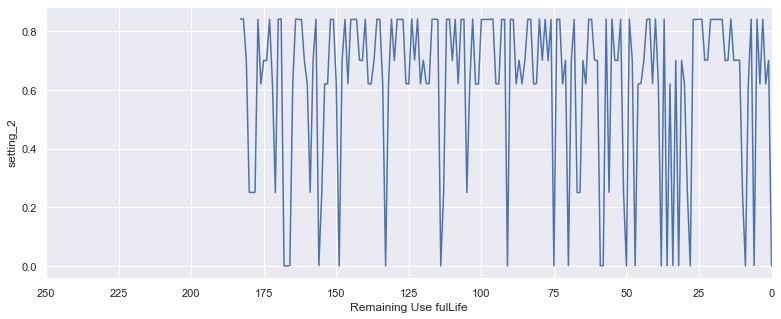

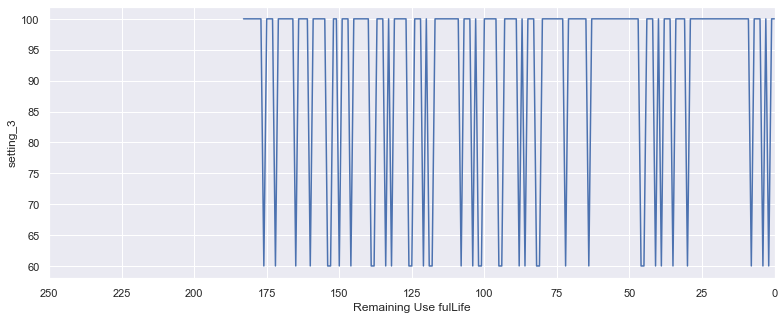

In [6]:
# RUL에 따른 setting_1,2,3의 값의 변화
for setting in setting_names:
    plot_signal(train, setting, unit_nr=10)

### 기준 모델(Base Line Model) - 성능을 개선해 나갈 모델
기준 모델은 단순 선형 회귀로 한다.  
본질적으로 우리가 하는 것은 계산된 RUL이 선형적으로 감소하도록 하는 대신
125 정도로 상한을 설정하여 clipping을 하는 것이다.  
(일반적인 선형 감소 RUL에 비해 훨씬 더 나은 결과를 생성)

In [7]:

X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

# get last row of each engine
X_test = test.drop('time_cycles', axis=1).groupby('unit_nr').last().copy() 

In [8]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [9]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:45.02973737819618, R2:0.576319327768421
test set RMSE:33.94272528221818, R2:0.6016440598064567


기준 모델이 RMSE가 33.94가 나왔으므로 이제 앞으로 해볼 NN으로는 이 성능을 이겨야 한다.

### Validation Set
신경망은 Overfitting에 매우 취약하다.   
test에서 실행하기 전에 모델 성능과 Overfitting을 개선하기 위해  
Validation set를 이용해야 한다.  

또한 단일 엔진의 모든 레코드가 Data Leakage를 방지하기 위해 Train 또는 Valid 세트에 할당되는 방식으로  
데이터를 분할해야 한다.  
-> sklearns의 GroupShuffleSplit 사용 ( 분할을 위한 그룹이 unit_nr로 이뤄짐.)

In [10]:
train['unit_nr'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [11]:
from sklearn.model_selection import GroupShuffleSplit
# 무작위 Group으로 묶어 Split? GSS

# eventhough we set np and tf seeds, gss requires its own seed
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  
# n_splits = 다시 섞기 및 분할 반복 횟수
# train_size = 0~1사이, test 분할에 포함할 그룹의 비율
# random_state = train 및 test 인덱스의 무작위성 정도


def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique(), '\n')
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

split_result = train_val_group_split(X_train, y_train_clipped, gss, train['unit_nr'])
X_train_split, y_train_clipped_split, X_val_split, y_val_clipped_split = split_result

train_split_engines [  1   2   3   4   5   6   8   9  12  13  14  15  17  18  21  22  23  24
  27  28  29  30  32  33  35  36  37  38  39  40  41  42  43  44  45  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  70  71  72  73  74  75  77  79  80  81  82  83  84  85  86  87
  88  89  90  92  94  95  96  99 100 101 103 104 106 107 108 109 110 111
 112 113 116 117 118 119 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 141 142 144 146 147 148 149 150 152 153 154
 156 157 158 160 161 162 163 164 165 166 167 169 170 171 172 173 175 176
 177 179 181 183 184 185 187 188 189 190 192 193 194 195 196 198 199 200
 201 203 204 208 209 210 211 215 216 217 218 219 220 222 223 225 226 227
 228 230 231 232 233 234 235 236 239 240 241 242 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 260] 

validate_split_engines [  7  10  11  16  19  20  25  26  31  34  46  47  69  76  78  91  93  97
  98 102 105 114 115 120 140 143 145 

valid 세트는 train 세트와 valid 세트 간의 모델 성능을 비교하기 위해서는  
유사한 분포! 를 가져야 한다.  
유사성을 파악하기 위해 대상 변수 분포를 확인하자.

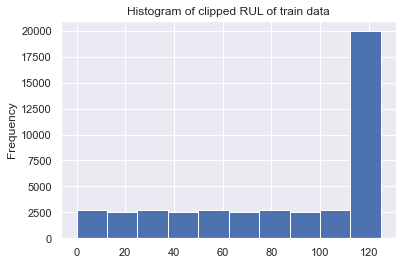

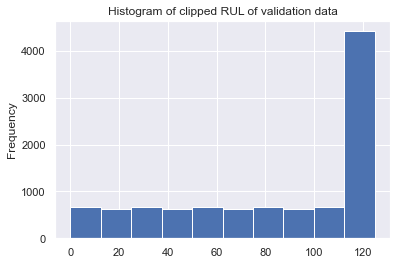

In [12]:
plt.figure()
y_train_clipped_split.plot(kind='hist')
plt.title("Histogram of clipped RUL of train data")
plt.show()
plt.close()

plt.figure()
y_val_clipped_split.plot(kind='hist')
plt.title("Histogram of clipped RUL of validation data")
plt.show()
plt.close()

# 음 히스토그램 (RUL의 분포) 가 비슷한 양상을 띈다! 굳

### 스케일링
SVM(Support Vector Regression)과 마찬가ㅣ로 NN은 데이터 포인트 간의 상대거리를 사용하는 경향이 있지만  
절대 차이 크기를 이해하는 데는 좋지 않으므로 스케일링 추가가 필요함!

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler() # 스케일링 추가
scaler.fit(X_train[sensor_names]) # 스케일링 fit 
X_train_scaled = X_train.copy()
X_train_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_train[sensor_names]), columns=sensor_names)


X_test_scaled = X_test.copy()
X_test_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_test[sensor_names]), columns=sensor_names, index=X_test.index)
# set index because unit_nr begins at 1 instead of 0

In [14]:
split_result = train_val_group_split(X_train_scaled, y_train_clipped, gss, train['unit_nr'], print_groups=True)
X_train_split_scaled, y_train_clipped_split_scaled, X_val_split_scaled, y_val_clipped_split_scaled = split_result

train_split_engines [  1   2   3   4   5   6   8   9  12  13  14  15  17  18  21  22  23  24
  27  28  29  30  32  33  35  36  37  38  39  40  41  42  43  44  45  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  70  71  72  73  74  75  77  79  80  81  82  83  84  85  86  87
  88  89  90  92  94  95  96  99 100 101 103 104 106 107 108 109 110 111
 112 113 116 117 118 119 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 141 142 144 146 147 148 149 150 152 153 154
 156 157 158 160 161 162 163 164 165 166 167 169 170 171 172 173 175 176
 177 179 181 183 184 185 187 188 189 190 192 193 194 195 196 198 199 200
 201 203 204 208 209 210 211 215 216 217 218 219 220 222 223 225 226 227
 228 230 231 232 233 234 235 236 239 240 241 242 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 260] 

validate_split_engines [  7  10  11  16  19  20  25  26  31  34  46  47  69  76  78  91  93  97
  98 102 105 114 115 120 140 143 145 

### 다중 퍼셉트론(MLP)
MLP는 비선형 패턴 학습에 적합하고, 입력, 은닉, 출력 레이어로 구성된 바닐라 NN을 살펴본다.

keras의 Sequential 레이러로 시작하여 Dense 레이어 몇 개를 추가하여 레이어의 노드 수를 지정하여 모델 개체를 만든다.  

입력 dimension은 첫 번째 Dense 레이어로 전달되어야 한다. 모델의 마지막 레이어는 단일 노드가 있는 Dense 레이어야 한다.  
마지막에는 단일 데이터 행에 대한 단일 값(RUL)을 반환해야 하기 떄문이다!



In [15]:
# 간단한 바닐라 NN 모델 정의 

train_cols = setting_names+sensor_names
input_dim = len(train_cols)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam') # 가중치 초기화

# 그리고 model.compile을 진행. 이 때 임의의 가중치가 초기화된다.

In [16]:
# 모델 훈련 model.fit

epochs = 20

history = model.fit(X_train_split_scaled[train_cols], y_train_clipped_split_scaled,
                    validation_data=(X_val_split_scaled[train_cols], y_val_clipped_split_scaled),
                    epochs=epochs)

Epoch 1/20
1359/1359 [==============================] - 3s 2ms/step - loss: 2014.1711 - val_loss: 1799.2775
Epoch 2/20
1359/1359 [==============================] - 3s 2ms/step - loss: 1698.3879 - val_loss: 1718.4039
Epoch 3/20
1359/1359 [==============================] - 4s 3ms/step - loss: 1647.4182 - val_loss: 1715.8828
Epoch 4/20
1359/1359 [==============================] - 5s 3ms/step - loss: 1608.9924 - val_loss: 1589.4333
Epoch 5/20
1359/1359 [==============================] - 4s 3ms/step - loss: 1552.8025 - val_loss: 1543.0820
Epoch 6/20
1359/1359 [==============================] - 3s 2ms/step - loss: 1487.9202 - val_loss: 1417.8356
Epoch 7/20
1359/1359 [==============================] - 3s 2ms/step - loss: 1370.7493 - val_loss: 1281.6930
Epoch 8/20
1359/1359 [==============================] - 3s 2ms/step - loss: 1175.3925 - val_loss: 1010.0795
Epoch 9/20
1359/1359 [==============================] - 2s 2ms/step - loss: 876.7484 - val_loss: 709.8662
Epoch 10/20
1359/1359 [=======

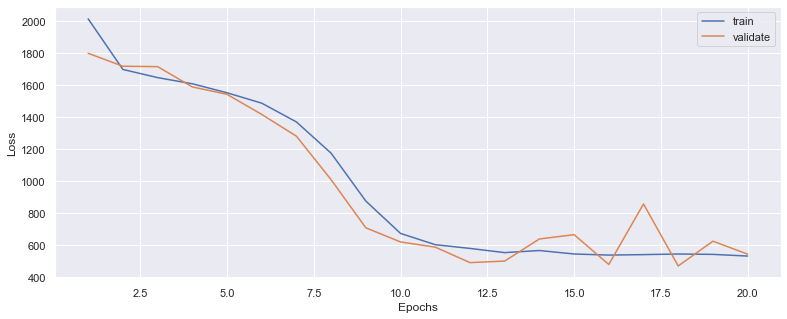

In [17]:
# 훈련이 잘 되고 있나 플로팅
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [18]:
# inference 진행
y_hat_train = model.predict(X_train_scaled[train_cols])
evaluate(y_train_clipped, y_hat_train, 'train') # 정답과 예측을 비교 train
 
y_hat_test = model.predict(X_test_scaled[train_cols]) # 정답과 예측을 비교 test
evaluate(y_test, y_hat_test)

train set RMSE:23.208026663795255, R2:0.6897375750788198
test set RMSE:33.622293309747896, R2:0.6091298150487404


이제 성능이 기준 모델에 근접한 NN을 완성하였다.  
이제 feature 엔지니어링을 시작해보자

### one-hot encoding
아까 FD002는 6가지 작동조건을 만들 수 있다고 했는데  
one-hot 인코딩을 하면 각각의 고유한 작동 조건이 카테고리가 될 수 있다.

-> 즉 각 행에는 하나의 고유한 작동 조건만 활성화된다.  
즉 하나의 열에만 1이 있고 다른 열에는 0이 있다.  


In [19]:
# setting_1,2,3을 round처리해서 6개의 범위의 조건으로 만든다.
X_train_condition = X_train.copy()
X_train_condition['setting_1'] = X_train_condition['setting_1'].round() 
X_train_condition['setting_2'] = X_train_condition['setting_2'].round(decimals=2)

# converting settings to string and concatanating makes the operating condition into a categorical variable
X_train_condition['op_cond'] = X_train_condition['setting_1'].astype(str) + '_' + \
                        X_train_condition['setting_2'].astype(str) + '_' + \
                        X_train_condition['setting_3'].astype(str)

op_cond = list(X_train_condition['op_cond'].unique())
op_cond

['35.0_0.84_100.0',
 '42.0_0.84_100.0',
 '25.0_0.62_60.0',
 '20.0_0.7_100.0',
 '0.0_0.0_100.0',
 '10.0_0.25_100.0']

In [20]:
pd.get_dummies(X_train_condition['op_cond'], drop_first=False).head()  # one-hot encoding, 각 열,행에서 하나만 활성화되게

0.0_0.0_100.0  10.0_0.25_100.0  20.0_0.7_100.0  25.0_0.62_60.0  \
0              0                0               0               0   
1              0                0               0               0   
2              0                0               0               1   
3              0                0               0               0   
4              0                0               0               1   

   35.0_0.84_100.0  42.0_0.84_100.0  
0                1                0  
1                0                1  
2                0                0  
3                0                1  
4                0                0

하지만 두 가지 문제가 존재한다.  
1. one hot 인코딩으로 인한 개선은 그렇게 크지 않다.  
2. 추가 feature 엔지니어링을 위한 공간을 거의 남기지 않는다.  
예를 들어 센서 신호가 작동 조건 사이에서 너무 많이 벗어날 때, 필터를 적용할 수 없다.  
3. 시차 변수를 추가하는 것은 비실용적이다. 시차도 변경되는 작동 조건을 설명하기 위해 포함되어야 하기 때문이다.  

### 조건 기반 표준화(Condition Based Scaler)
아까 진행했던 스케일링은 MinMax Scaling이다. 그런데 Condition Based Scaler는 단일 작동 조건의 모든 레코드를  
그룹화하고, 표준 스케일러를 사용하여 확장한다.  

-> 작동 조건이 6개이기에, 그룹화를 해야 하고 조건 기반 표준화를 해야한다는 것!  
이런 스케일링을 적용하면 그룹화된 작동 조건의 평균이 0이 된다.  
이 표준화는 각 작동조건에 개별적으로 적용하기 때문에 모든 신호가 평균이 0으로 되어 어느 정도 동일한 라인에서  
비교가 가능하게끔 한다.  

이 표준화는 신호가 유사한 동작을 갖지만, 다른 평균을 중심으로 하는 경우에 매우 잘 작동한다.  

-> 작동 족너 자체가 고장의 임박성에 영향을 미치지 않는 경우에만 사용할 수 있다!!는 것을 유의해야 한다.

In [21]:
# one-hot encoding 처럼 setting_1,2,3을 round처리를 하여 카테고리처럼 만든다.
def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['setting_1'] = df_op_cond['setting_1'].round()
    df_op_cond['setting_2'] = df_op_cond['setting_2'].round(decimals=2)
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)
    
    return df_op_cond

X_train_condition = add_operating_condition(train) # X_train_condition은 기존 train df에 작동 조건 6개를 추가한 df
X_test_condition = add_operating_condition(X_test)

In [22]:
X_train_condition # op_cond를 만들어냈다. 6가지 종류가 있음.

unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0            1            1       35.0       0.84      100.0  449.44  555.32   
1            1            2       42.0       0.84      100.0  445.00  549.90   
2            1            3       25.0       0.62       60.0  462.54  537.31   
3            1            4       42.0       0.84      100.0  445.00  549.51   
4            1            5       25.0       0.62       60.0  462.54  537.07   
...        ...          ...        ...        ...        ...     ...     ...   
53754      260          312       20.0       0.70      100.0  491.19  608.79   
53755      260          313       10.0       0.25      100.0  489.05  605.81   
53756      260          314       25.0       0.62       60.0  462.54  537.48   
53757      260          315       25.0       0.62       60.0  462.54  537.84   
53758      260          316       35.0       0.84      100.0  449.44  556.64   

           s_3      s_4    s_5  ...     s_14     s_15  s_16  s_17  s_18  \
0      1358.61  1137.23   5.48  ...  8048.56   9.3461  0.02   334  2223   
1      1353.22  1125.78   3.91  ...  8072.30   9.3774  0.02   330  2212   
2      1256.76  1047.45   7.05  ...  7864.87  10.8941  0.02   309  1915   
3      1354.03  1126.38   3.91  ...  8068.66   9.3528  0.02   329  2212   
4      1257.71  1047.93   7.05  ...  7861.23  10.8963  0.02   309  1915   
...        ...      ...    ...  ...      ...      ...   ...   ...   ...   
53754  1495.60  1269.51   9.35  ...  8169.64   9.3035  0.03   369  2324   
53755  1514.32  1324.12  10.52  ...  8245.36   8.7586  0.03   374  2319   
53756  1276.24  1057.92   7.05  ...  7971.25  11.0657  0.02   310  1915   
53757  1272.95  1066.30   7.05  ...  7972.47  11.0537  0.02   311  1915   
53758  1374.61  1145.52   5.48  ...  8185.35   9.3998  0.02   338  2223   

         s_19   s_20     s_21  RUL          op_cond  
0      100.00  14.73   8.8071  148  35.0_0.84_100.0  
1      100.00  10.41   6.2665  147  42.0_0.84_100.0  
2       84.93  14.08   8.6723  146   25.0_0.62_60.0  
3      100.00  10.59   6.4701  145  42.0_0.84_100.0  
4       84.93  14.13   8.5286  144   25.0_0.62_60.0  
...       ...    ...      ...  ...              ...  
53754  100.00  24.36  14.5189    4   20.0_0.7_100.0  
53755  100.00  28.10  16.9454    3  10.0_0.25_100.0  
53756   84.93  14.19   8.5503    2   25.0_0.62_60.0  
53757   84.93  14.05   8.3729    1   25.0_0.62_60.0  
53758  100.00  14.75   8.8446    0  35.0_0.84_100.0  

[53759 rows x 28 columns]

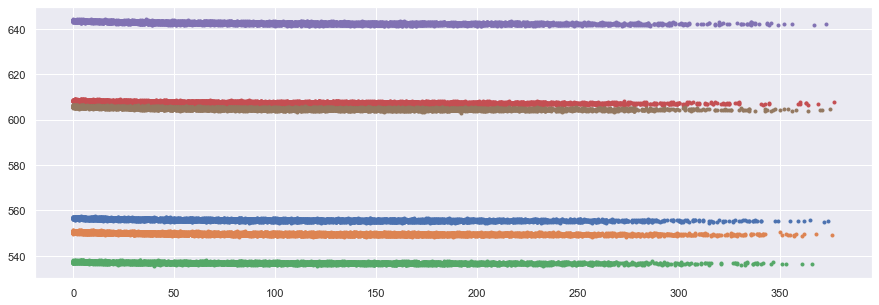

In [23]:
# 그 다음 작동 조건 별로 RUL이 어떻게 분포하는지 s_2의 경우를 예로 들어 확인해보자.
plt.figure(figsize=(15,5))

for condition in op_cond:
    data = X_train_condition.loc[X_train_condition['op_cond']==condition]
    plt.plot(data['RUL'], data['s_2'], '.')

플로팅 결과 6가지의 작동조건마다 평균은 각자 다르지만 유사한 동작을 보인다.  
마지막으로 Condition Based Scaler를 추가하여 센서 값들을 확인해보자.

In [24]:
X_train_condition['op_cond']

0        35.0_0.84_100.0
1        42.0_0.84_100.0
2         25.0_0.62_60.0
3        42.0_0.84_100.0
4         25.0_0.62_60.0
              ...       
53754     20.0_0.7_100.0
53755    10.0_0.25_100.0
53756     25.0_0.62_60.0
53757     25.0_0.62_60.0
53758    35.0_0.84_100.0
Name: op_cond, Length: 53759, dtype: object

In [25]:
# 조건 기반 스케일러 정의
def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

In [26]:
# 조건 기반 스케일링을 거친 후 train 데이터프레임
X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)
X_test_condition_scaled.head()

setting_1  setting_2  setting_3           s_1       s_2       s_3  \
unit_nr                                                                      
1             10.0       0.25      100.0 -1.136868e-13  1.067757  2.243249   
2              0.0       0.00      100.0  0.000000e+00 -0.017587  0.207384   
3             35.0       0.84      100.0  5.684342e-14  0.138436  0.695713   
4             20.0       0.70      100.0  2.273737e-13  0.918094  0.406796   
5             42.0       0.84      100.0  0.000000e+00  2.553217  0.796509   

              s_4           s_5       s_6       s_7  ...      s_13      s_14  \
unit_nr                                              ...                       
1        1.633786  0.000000e+00  1.429549 -1.109478  ...  1.619153  1.993314   
2        1.041724 -3.552714e-15  0.131140 -0.000836  ...  0.290831 -0.214174   
3        0.548449 -1.776357e-15 -0.174690  0.286740  ... -0.227555 -0.062787   
4        0.560935  1.776357e-15  0.713320 -0.176094  ... -0.263652 -0.232749   
5        1.641733  1.332268e-15  0.844057 -0.479111  ...  3.116996  3.125538   

             s_15          s_16      s_17  s_18  s_19      s_20      s_21  \
unit_nr                                                                     
1        2.120741 -1.387779e-17  0.873173   0.0   0.0 -1.571362 -0.260551   
2       -0.472348 -1.387779e-17 -0.130505   0.0   0.0  0.014174  0.533134   
3       -0.600083  3.469447e-18 -1.591890   0.0   0.0 -0.713689  0.908522   
4        0.056746 -5.221511e-01 -0.262250   0.0   0.0 -1.734068  0.108079   
5        0.568977  3.469447e-18  1.372567   0.0   0.0 -2.283410  0.137583   

                 op_cond  
unit_nr                   
1        10.0_0.25_100.0  
2          0.0_0.0_100.0  
3        35.0_0.84_100.0  
4         20.0_0.7_100.0  
5        42.0_0.84_100.0  

[5 rows x 25 columns]

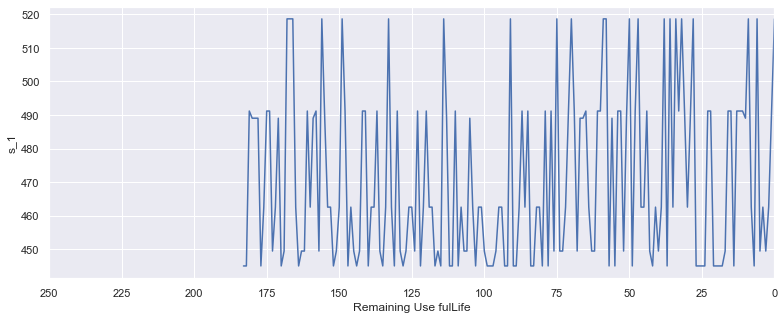

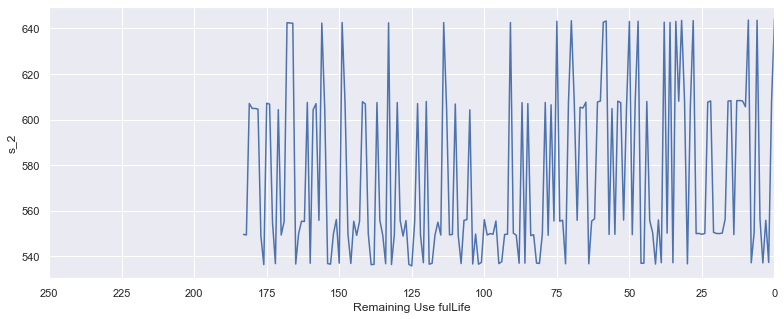

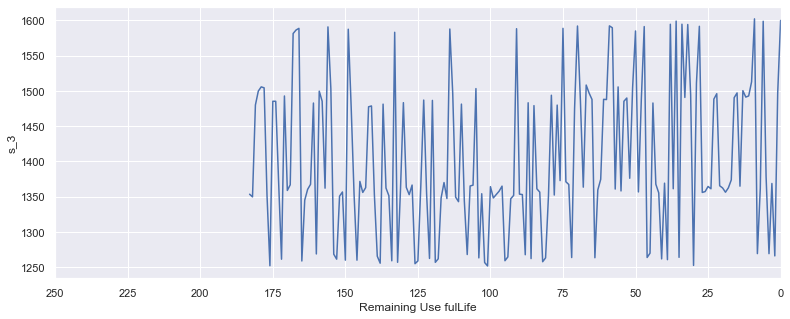

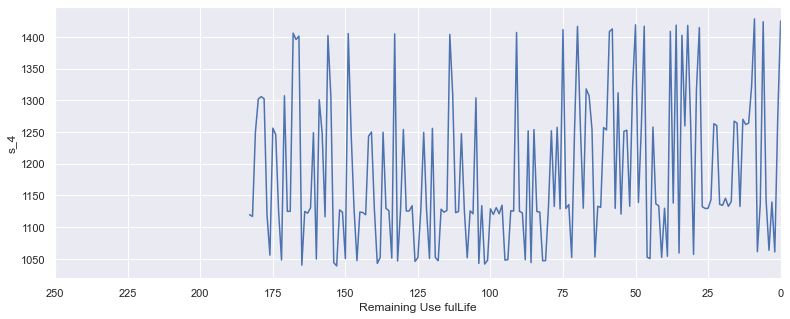

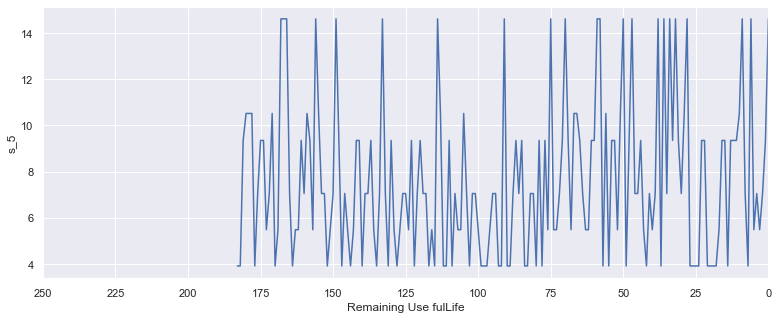

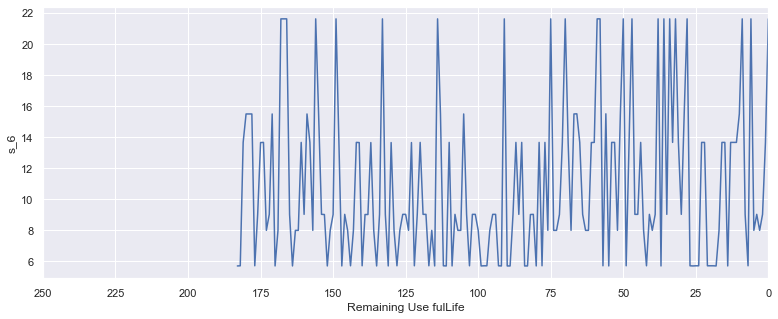

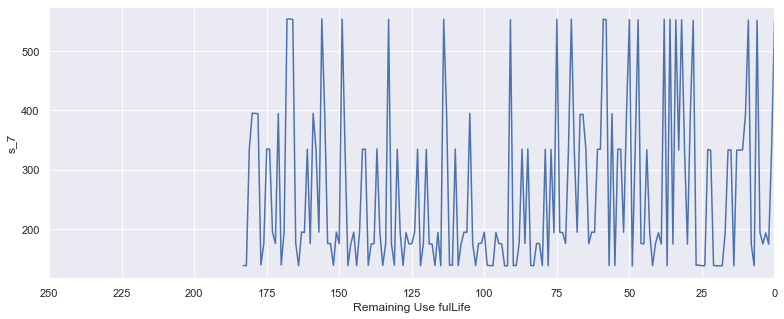

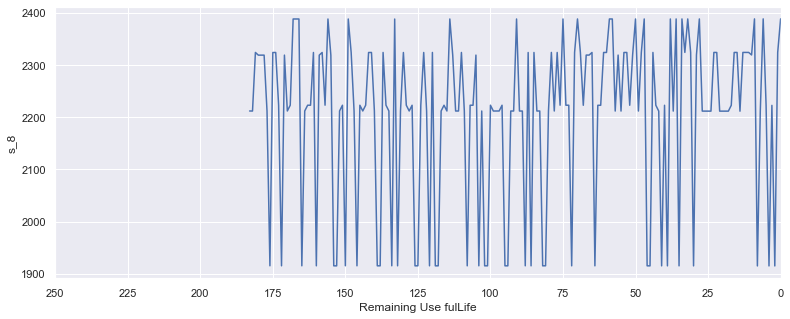

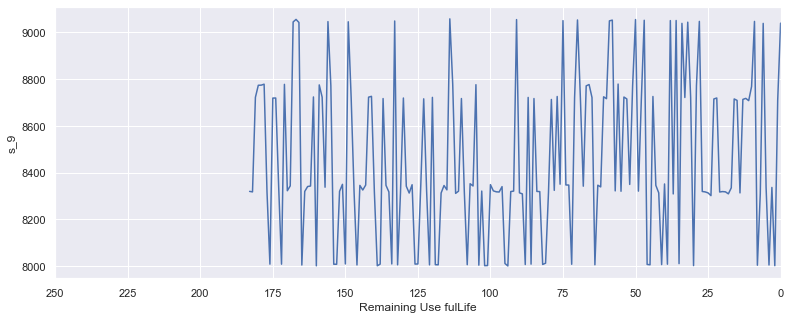

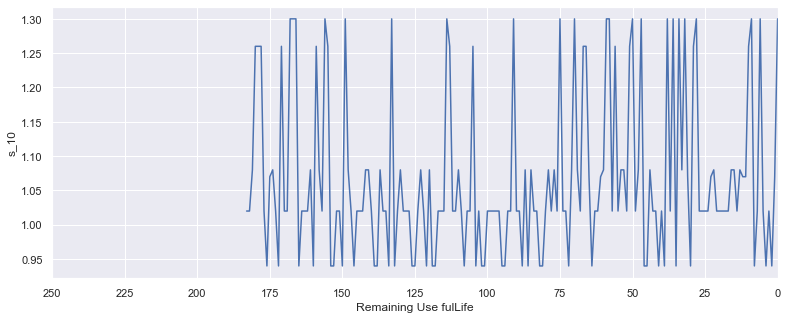

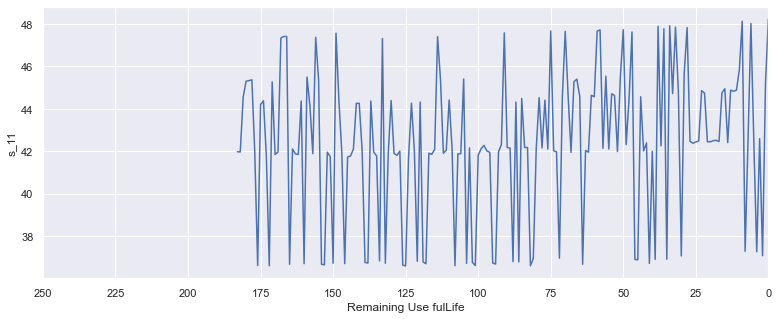

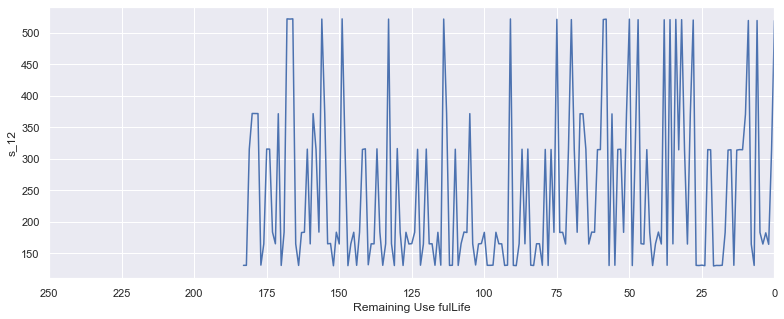

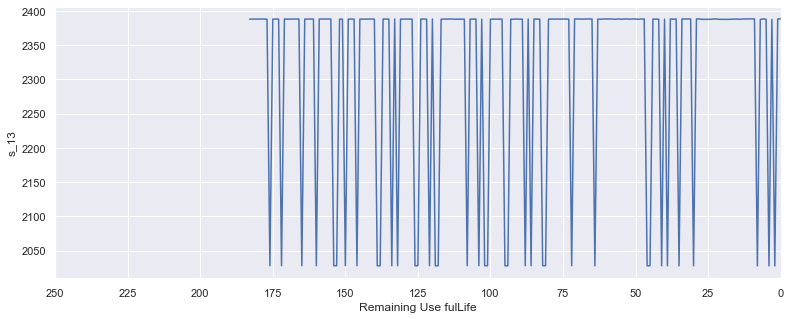

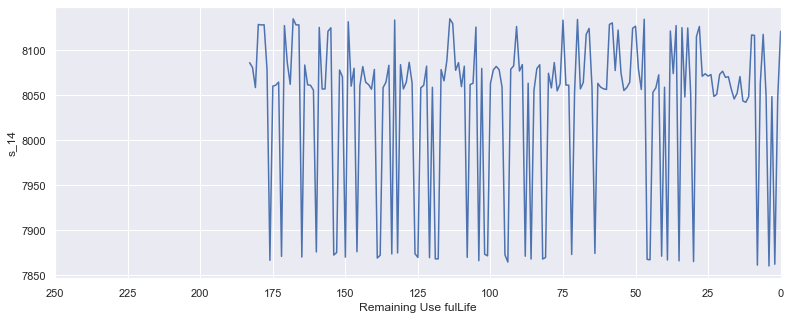

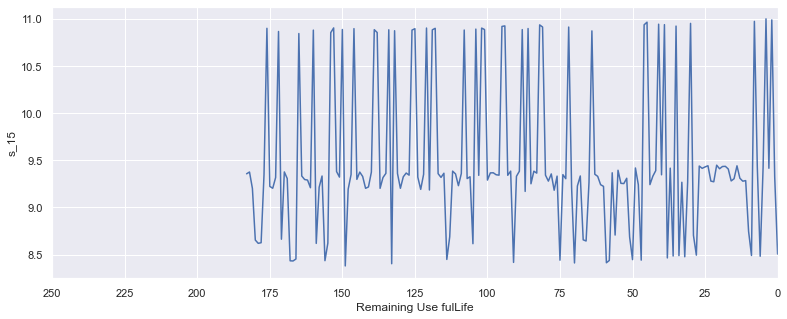

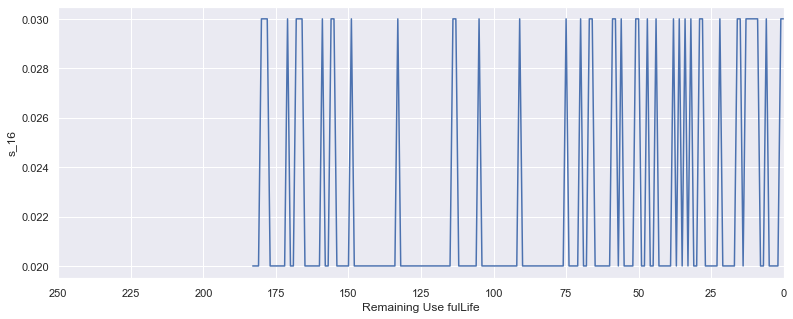

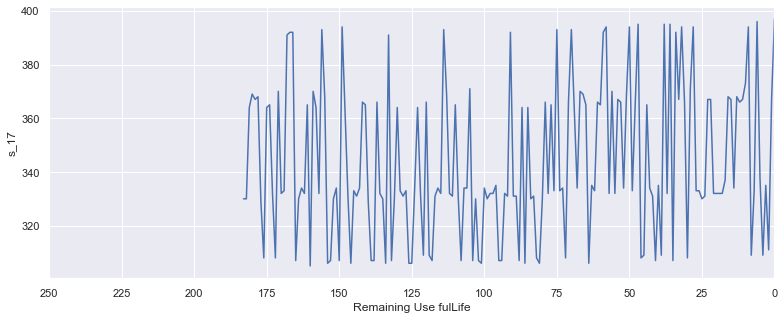

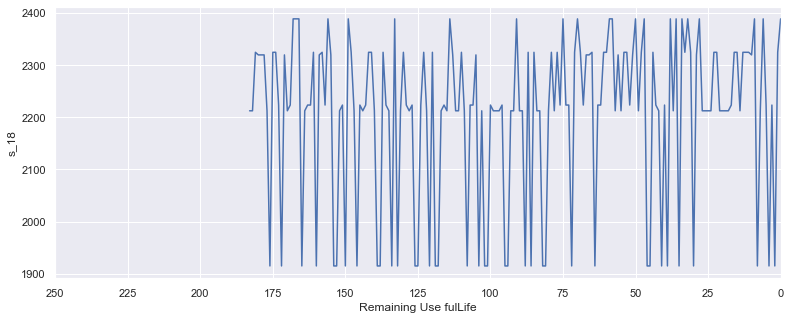

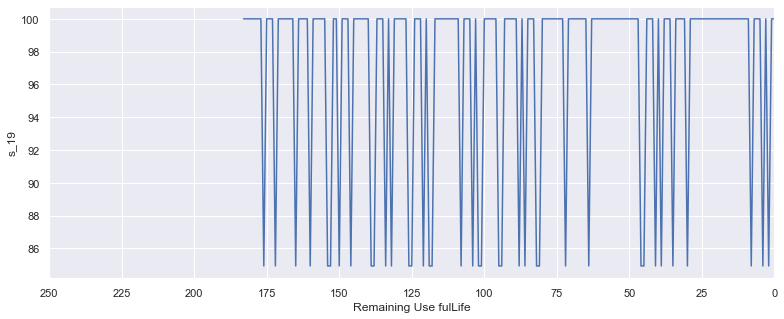

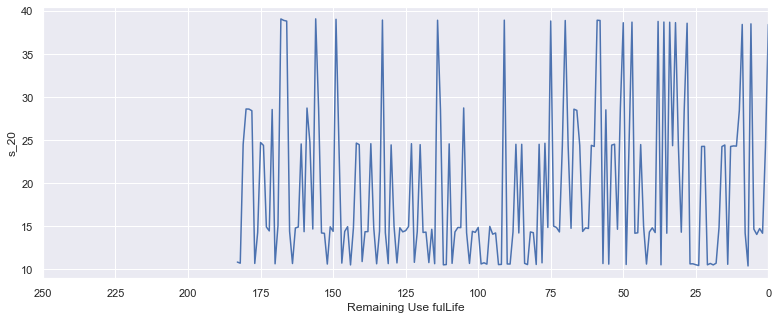

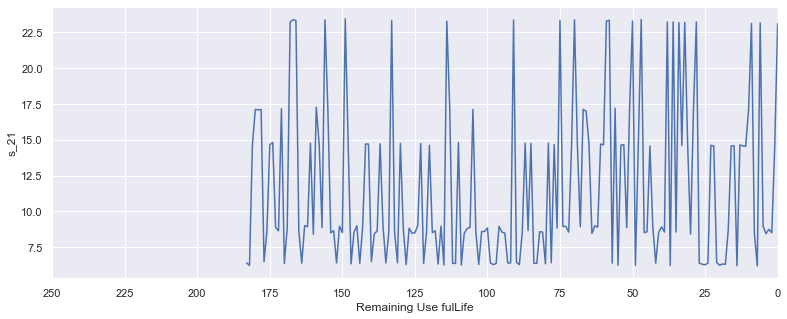

In [27]:
for sensor in sensor_names:  # compare train vs condition scaled
    plot_signal(train, sensor, unit_nr=10)

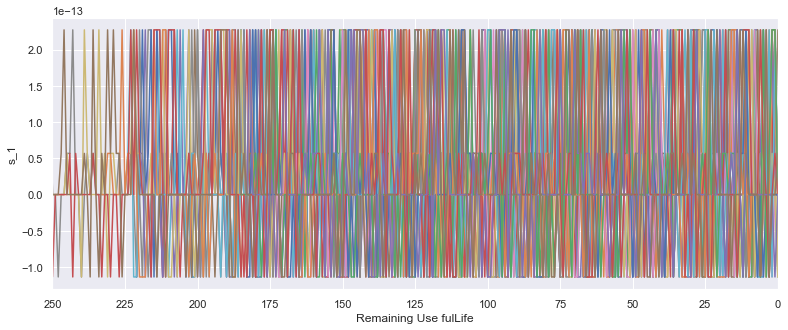

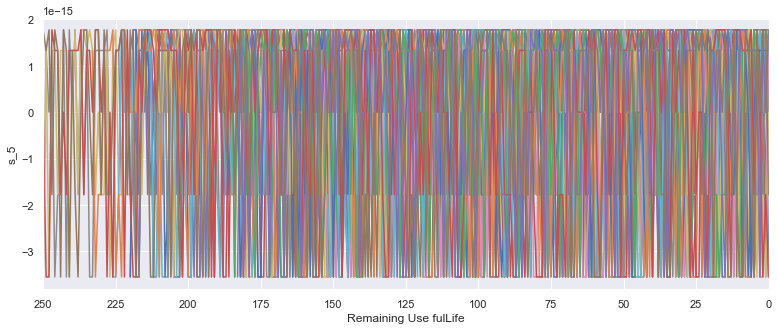

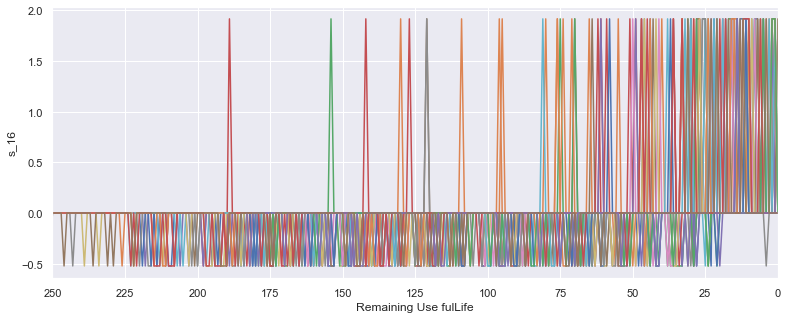

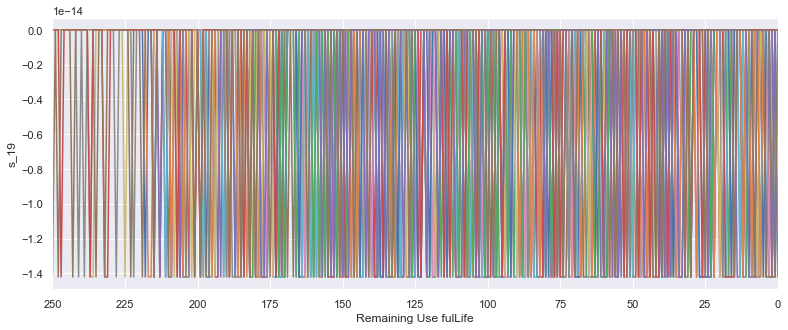

In [28]:
# s_1~s_21까지 unit 별로 색을 다르게 해서 ploting을 해보자! scaling 하고 어떻게 달라지는지
for sensor in ['s_1','s_5','s_16','s_19']:
    plot_signal(X_train_condition_scaled, sensor) # 알아볼 수 없는 센서들

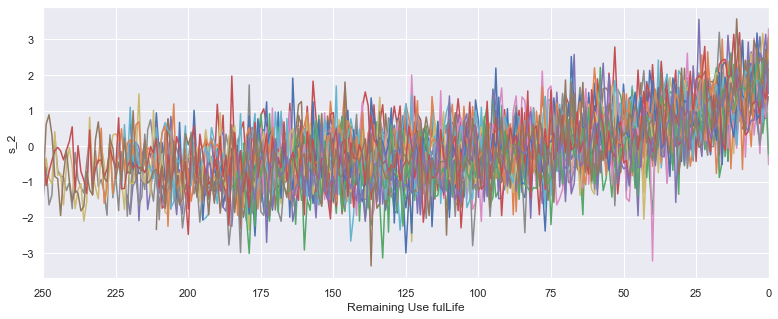

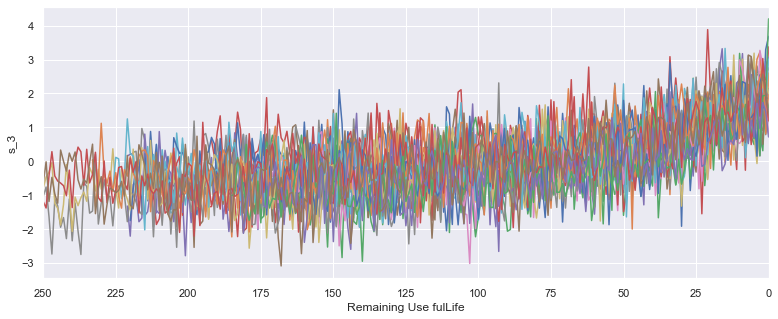

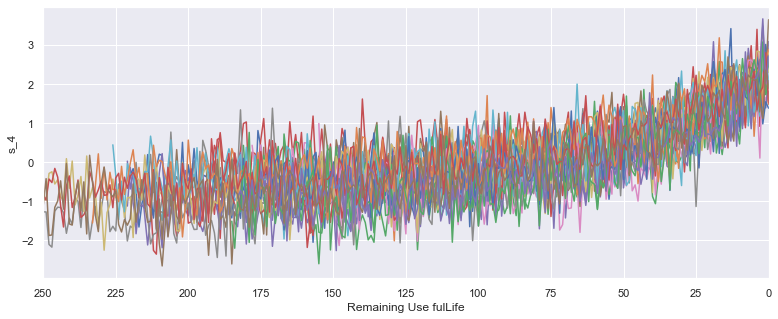

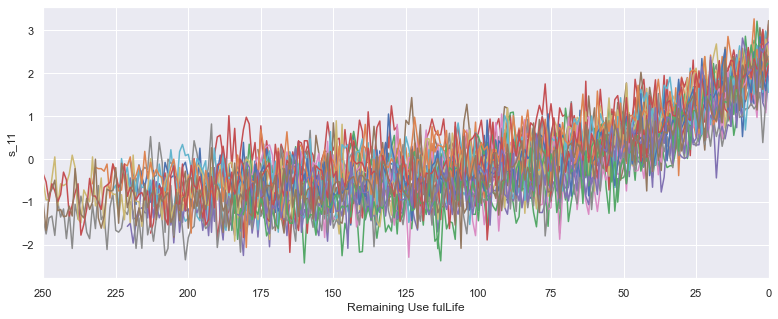

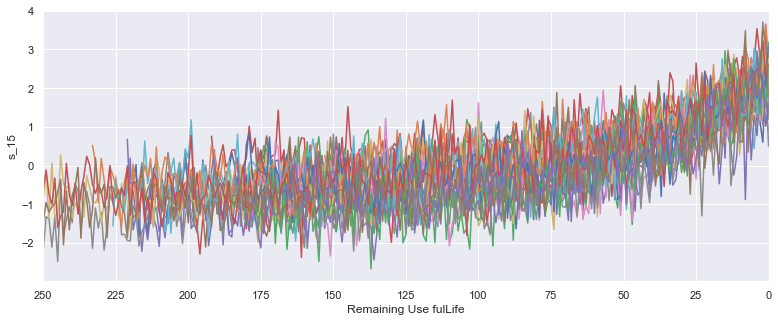

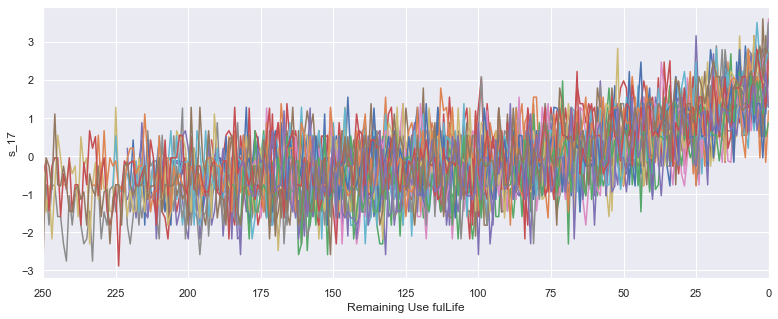

In [29]:
for sensor in ['s_2','s_3','s_4','s_11','s_15','s_17']: # 상승 추세
    plot_signal(X_train_condition_scaled, sensor)

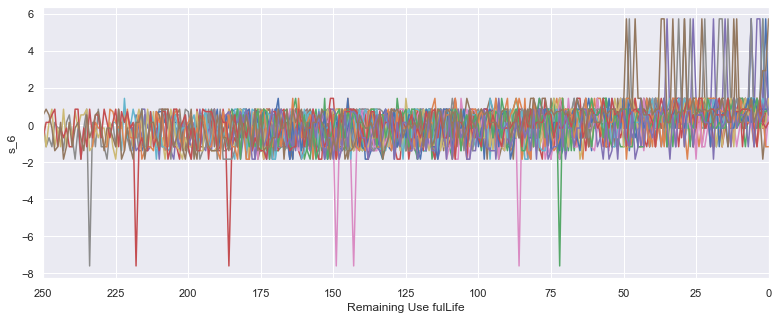

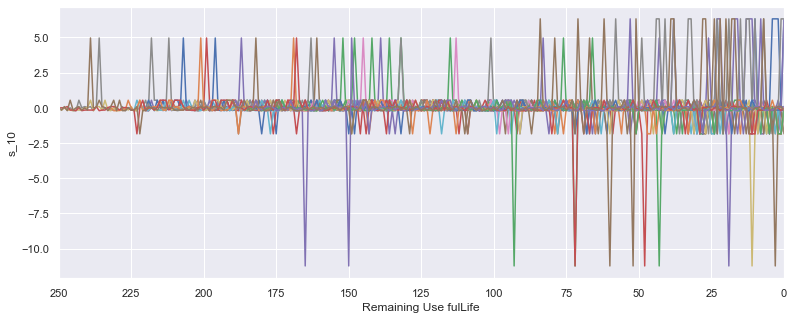

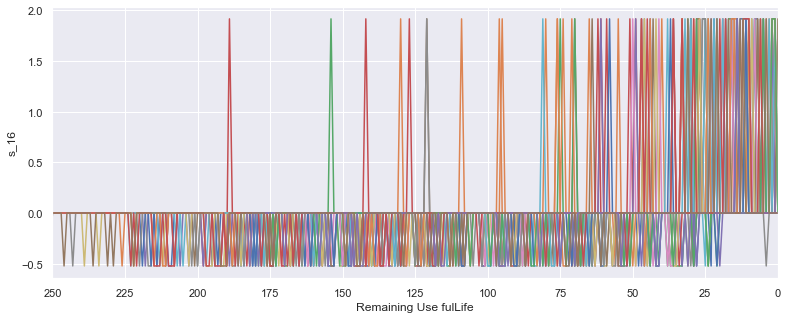

In [30]:
for sensor in ['s_6','s_10','s_16']: # 이상한 값
    plot_signal(X_train_condition_scaled, sensor)

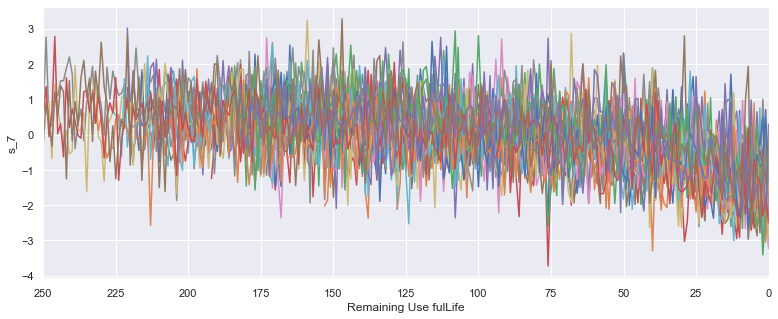

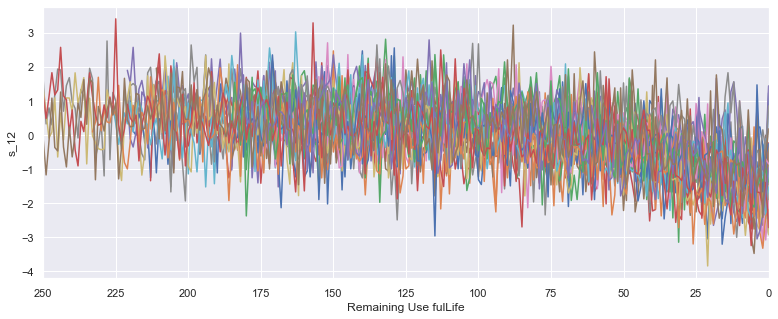

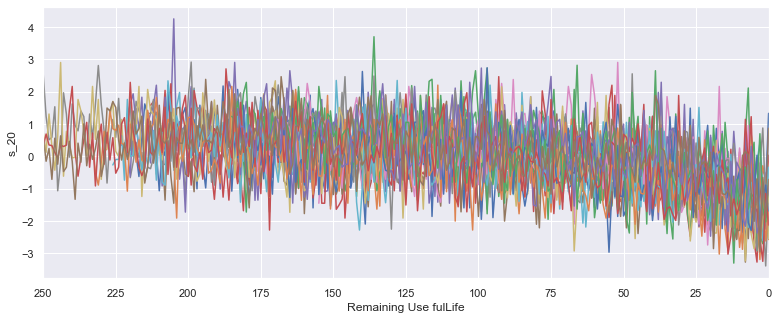

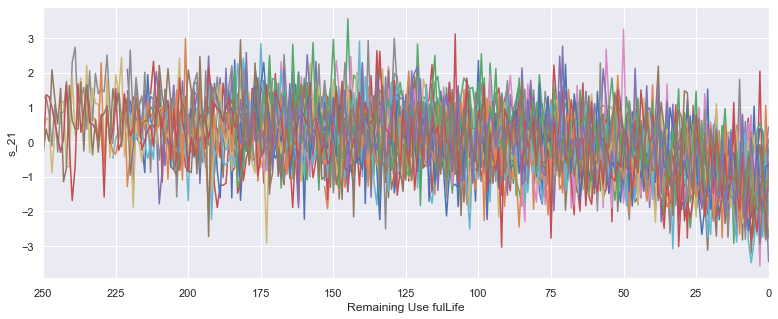

In [31]:
for sensor in ['s_7','s_12','s_20','s_21']: # 하향 추세
    plot_signal(X_train_condition_scaled, sensor)

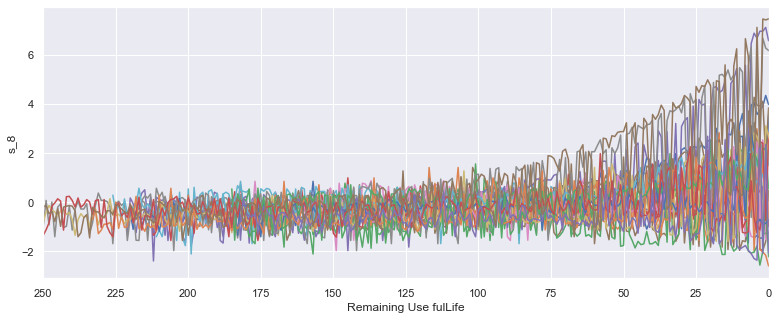

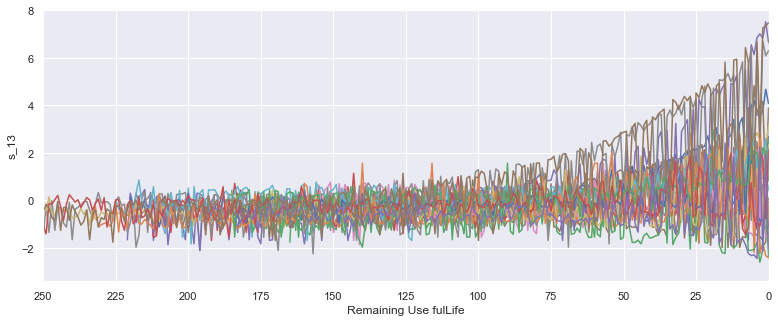

In [32]:
for sensor in ['s_8','s_13']:
    plot_signal(X_train_condition_scaled, sensor) # 위아래로 점프하는 중.. 표준화가 완전히 작동하지 않은 듯? noisy하다.

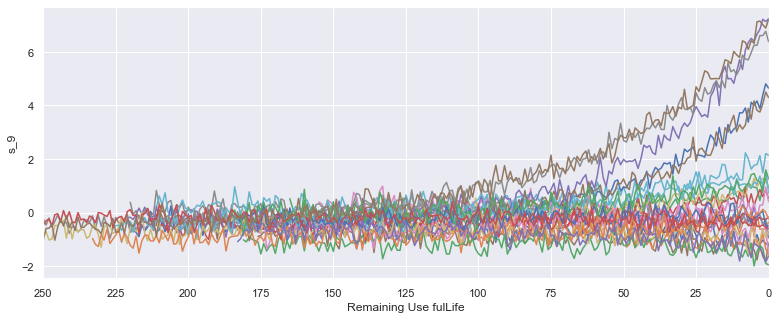

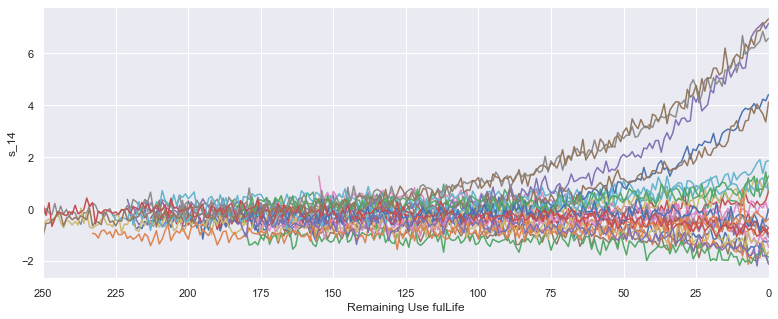

In [33]:
for sensor in ['s_9','s_14']:
    plot_signal(X_train_condition_scaled, sensor) # 여러 갈래로 나뉜 센서

그럼 간단하게 작동 조건 6가지를 고려한 센서 EDA를 마쳤으니 새 모델을 피팅해보자.  
일단 사용할 센서만 남긴다.

In [34]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

drop_sensors = [element for element in sensor_names if element not in remaining_sensors]
drop_sensors  # returns: ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']

['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']

Epoch 1/20
1359/1359 [==============================] - 3s 2ms/step - loss: 1131.1821 - val_loss: 413.3890
Epoch 2/20
1359/1359 [==============================] - 3s 2ms/step - loss: 413.9804 - val_loss: 393.3126
Epoch 3/20
1359/1359 [==============================] - 3s 2ms/step - loss: 400.7972 - val_loss: 389.5033
Epoch 4/20
1359/1359 [==============================] - 3s 2ms/step - loss: 393.3252 - val_loss: 380.2435
Epoch 5/20
1359/1359 [==============================] - 3s 2ms/step - loss: 386.9091 - val_loss: 408.0727
Epoch 6/20
1359/1359 [==============================] - 3s 2ms/step - loss: 385.6158 - val_loss: 391.7165
Epoch 7/20
1359/1359 [==============================] - 3s 2ms/step - loss: 382.9442 - val_loss: 379.2110
Epoch 8/20
1359/1359 [==============================] - 3s 2ms/step - loss: 381.0355 - val_loss: 386.7369
Epoch 9/20
1359/1359 [==============================] - 3s 2ms/step - loss: 381.2976 - val_loss: 379.0463
Epoch 10/20
1359/1359 [======================

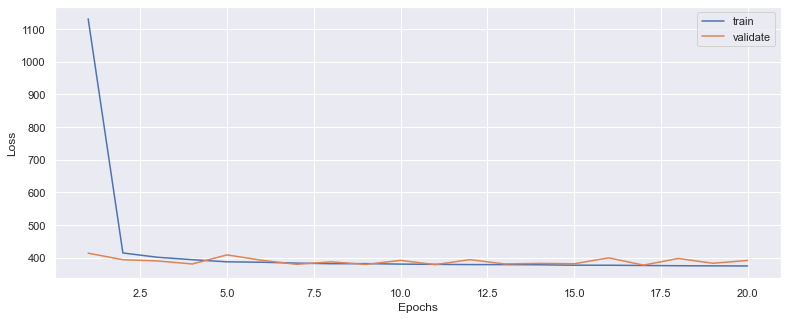

In [35]:
# NN 피팅
split_result = train_val_group_split(X_train_condition_scaled, y_train_clipped, gss, train['unit_nr'], print_groups=False)
X_train_split_condition_scaled, y_train_clipped_split_condition_scaled = split_result[:2]
X_val_split_condition_scaled, y_val_clipped_split_condition_scaled = split_result[2:]

# we have to redefine our model as our inputs changed
input_dim = len(X_train_split_condition_scaled[remaining_sensors].columns)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train_split_condition_scaled[remaining_sensors], y_train_clipped_split_condition_scaled,
                    validation_data=(X_val_split_condition_scaled[remaining_sensors], y_val_clipped_split_condition_scaled),
                    epochs=epochs)
plot_loss(history)

In [36]:
# 모델 평가

y_hat_train = model.predict(X_train_condition_scaled[remaining_sensors])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = model.predict(X_test_condition_scaled[remaining_sensors])
evaluate(y_test, y_hat_test)


train set RMSE:19.340404910390138, R2:0.7845314557819502
test set RMSE:29.093476148063676, R2:0.7073361315519289


아까 NN보다 조금 더 개선된 RMSE를 보였다.  
이제 더 개선하기 위해 지연 변수를 추가해보자.

### 지연 변수
시계열 데이터에서는 지연 변수를 추가해 모델에 이전 시계열 정보까지 제공하여  
원하는 t 시점의 정보를 regressoin할 수 있게 하자.  
여러 주기의 정보를 결합하면 모델이 추세를 감지하고 데이터를 보다 완벽히 볼 수 있다.  

In [37]:
# 지연 변수 추가 함수 정의
def add_specific_lags(df_input, list_of_lags, columns):
    df = df_input.copy()
    for i in list_of_lags:
        lagged_columns = [col + '_lag_{}'.format(i) for col in columns]
        df[lagged_columns] = df.groupby('unit_nr')[columns].shift(i)
    df.dropna(inplace=True)
    return df

Epoch 1/20
1229/1229 [==============================] - 3s 3ms/step - loss: 1154.0320 - val_loss: 396.2631
Epoch 2/20
1229/1229 [==============================] - 3s 2ms/step - loss: 410.2416 - val_loss: 380.1102
Epoch 3/20
1229/1229 [==============================] - 3s 2ms/step - loss: 375.6525 - val_loss: 348.5276
Epoch 4/20
1229/1229 [==============================] - 3s 2ms/step - loss: 358.7526 - val_loss: 408.4913
Epoch 5/20
1229/1229 [==============================] - 3s 2ms/step - loss: 347.0645 - val_loss: 350.7312
Epoch 6/20
1229/1229 [==============================] - 3s 2ms/step - loss: 340.9232 - val_loss: 352.9092
Epoch 7/20
1229/1229 [==============================] - 3s 2ms/step - loss: 337.1077 - val_loss: 335.2007
Epoch 8/20
1229/1229 [==============================] - 3s 2ms/step - loss: 332.9944 - val_loss: 352.3174
Epoch 9/20
1229/1229 [==============================] - 3s 2ms/step - loss: 328.7140 - val_loss: 346.4351
Epoch 10/20
1229/1229 [======================

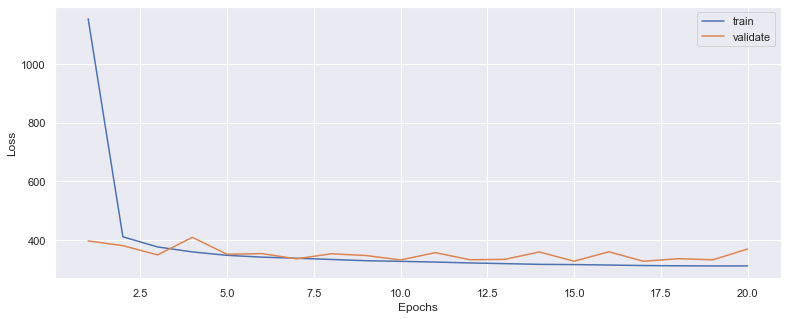

In [38]:
# 저번에 괜찮았던 지연 변수, t-1, t-2, t-3, t-4, t-5.. 로 X_train_condition을 만들자.
specific_lags = [1,2,3,4,5,10,20]  # laggs which worked well in the timeseries solution for FD001

# prep data
X_train_condition = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_condition = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, remaining_sensors)

X_train_condition_scaled_lagged = add_specific_lags(X_train_condition_scaled, specific_lags, remaining_sensors)
X_test_condition_scaled_lagged = add_specific_lags(X_test_condition_scaled, specific_lags, remaining_sensors)

X_train_condition_scaled_lagged.drop(index_names+setting_names+['op_cond', 'RUL'], axis=1, inplace=True)
X_test_condition_scaled_lagged = X_test_condition_scaled_lagged.drop(['time_cycles', 'op_cond']+setting_names, axis=1).groupby('unit_nr').last().copy()

idx = X_train_condition_scaled_lagged.index
y_train_clipped_lagged = y_train_clipped.iloc[idx]

split_result = train_val_group_split(X_train_condition_scaled_lagged, y_train_clipped_lagged, gss, train.iloc[idx]['unit_nr'], print_groups=False)
X_train_split_condition_scaled_lagged, y_train_clipped_split_lagged = split_result[:2]
X_val_split_condition_scaled_lagged, y_val_clipped_split_lagged = split_result[2:]

# we have to redefine our model as the input dimensions have changed
input_dim = len(X_train_split_condition_scaled_lagged.columns)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train_split_condition_scaled_lagged, y_train_clipped_split_lagged,
                    validation_data=(X_val_split_condition_scaled_lagged, y_val_clipped_split_lagged),
                    epochs=epochs)

plot_loss(history)

In [39]:
y_hat_train = model.predict(X_train_condition_scaled_lagged)
evaluate(y_train_clipped_lagged, y_hat_train, 'train')

y_hat_test = model.predict(X_test_condition_scaled_lagged)
evaluate(y_test, y_hat_test)

train set RMSE:17.90370299101539, R2:0.8169024456478836
test set RMSE:28.967709245118108, R2:0.7098609499372464


지연 변수를 추가하였더니.. RMSE가 거의 개선되지는 않았다.  
이는 약간의 Overfitting이 발생하였기 때문인 것 같다.

### 정지와 평활화(Smoothing)
원래는 데이터를 고정적으로 만들려고 했다(고정적 : 시간이 지남에 따라 신호의 통계적 속성이 변하지 않는 것)  
이러한 고정성으로 인해 통계 모델은 미래 값을 잘 예측할 수 있다.  

고정성 테스트는 지난번에 했던 것처럼 Adfuller 테스트를 사용하면 테스트 할 수 있다.  
만약 테스트를 통과하지 못했으면 데이터를 한번 구분하여 추세를 제거하고 다시 테스트한다.  

아까 지연변수를 추가했기에 처음 t,t-1,t-2.. 에 따라 NA값이 채워진다(기존에 없는 값들이 지연되므로)  
그래서 NA를 삭제해야 하며, 지연 수를 결정하는 것이 중요해진다.  

데이터를 고정시키는 것이 중요한 포인트이다.

-> 조건 기반 표준화를 한 후 데이터의 정상성을 확인해보자.

Original signal assumed stationary?  True


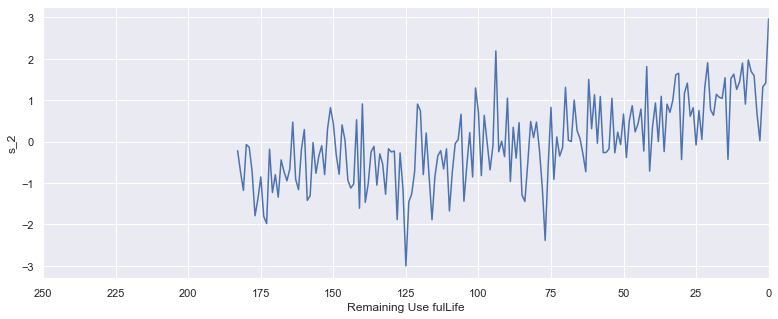

In [40]:
# 예시로 s_2에 대해 고정성 테스트를 진행.

from statsmodels.tsa.stattools import adfuller # adfuller import

X_train_condition = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_condition = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_condition_scaled, _ = condition_scaler(X_train_condition, X_test_condition, remaining_sensors)


adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(
                                            X_train_condition_scaled.loc[X_train_condition_scaled['unit_nr'] == 10,'s_2'], 
                                            maxlag=1)
print('Original signal assumed stationary? ', pvalue < 0.05)
plot_signal(X_train_condition_scaled, 's_2', 10) # s_2에 대해, 다른 센서들도 해보자.

Original signal assumed stationary?  True


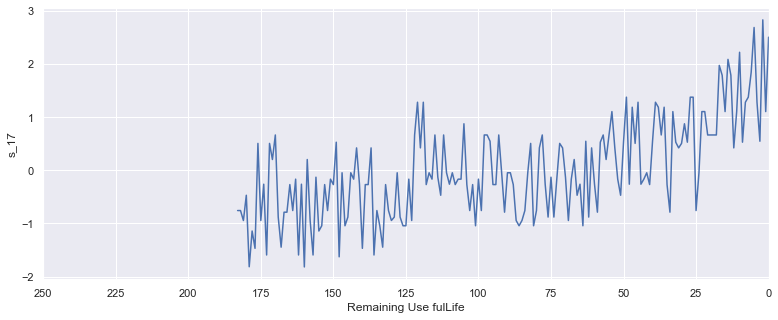

In [41]:
# 예시로 s_17에 대해 고정성 테스트를 진행.

from statsmodels.tsa.stattools import adfuller # adfuller import

X_train_condition = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_condition = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_condition_scaled, _ = condition_scaler(X_train_condition, X_test_condition, remaining_sensors)


adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(
                                            X_train_condition_scaled.loc[X_train_condition_scaled['unit_nr'] == 10,'s_17'], 
                                            maxlag=1)
print('Original signal assumed stationary? ', pvalue < 0.05)
plot_signal(X_train_condition_scaled, 's_17', 10) # s_17에 대해, 다른 센서들도 해보자.

약간의 추세가 보이지만 이 신호는 고정된 것으로 간주될 수 있으며 대부분 신호가 고정됨을 확인할 수 있다.

### 평활화(Smoothing)
평활화를 위해 '지수 가중 이동 평균'을 구현한다. (이 함수는 pandas 내에 이미 구현되어있다! -> ewm라는 것을 사용)   
이것은 평활화 기능 중 하나로, 필터링이다.  
데이터를 Smoothing하면 추세를 더 잘 볼 수 있을 듯?

~Xt = a*Xt + (1 - a)*~Xt-1

이 공식을 사용한다!

여기서 ~Xt는 Xt의 필터링된 값이고, 필터의 강도는 a이다. 이전 값을 많이 반영할 거면 a를 작게,  
현재 측정값을 많이 적용할 거면 a를 크게 한다.  
a(알파) 는 0~1사이 값이다.  

예를 들어 알파가 0.8이면 필터링된 데이터 포인트 Xt에서 값의 80%와 Xt-1에서 (이미 필터링된) 값의 20%로 구성된다.  
-> 알파 값이 작을 수록 Smoothing 효과는 강해짐. (이전 값을 많이 반영함. 크게 변하지 않게)



Smoothed signal assumed stationary?  False


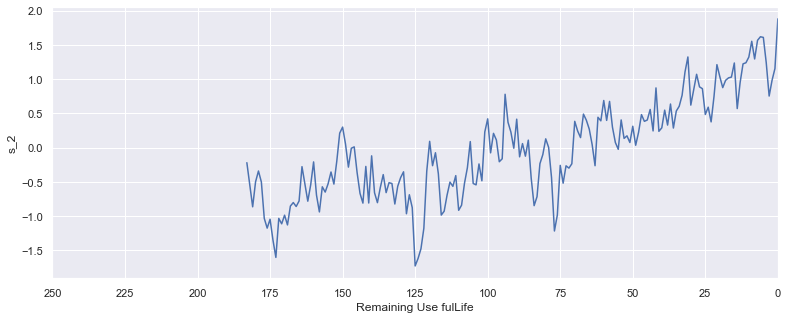

In [42]:
# 아까 그 s_2 고정성 테스트 진행 시 smoothing을 적용해보자. ewm라는 것을 사용.
# smaller values of alpha provide a stronger filter effect
X_train_condition_scaled_smoothed = X_train_condition_scaled.copy()
X_train_condition_scaled_smoothed[remaining_sensors] = X_train_condition_scaled_smoothed.groupby(
                                                    'unit_nr')[remaining_sensors].apply(lambda x: x.ewm(alpha=0.4).mean())

# Stationarity after condition based standardization and smoothing
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(
                            X_train_condition_scaled_smoothed.loc[X_train_condition_scaled_smoothed['unit_nr'] == 10,'s_2'],
                            maxlag=1)
print('Smoothed signal assumed stationary? ', pvalue < 0.05)
plot_signal(X_train_condition_scaled_smoothed, 's_2', 10)

평활화 후 신호는 더 이상 고정된 것으로 간주하지 않는다.   
알파 값에 따라 신호의 노이즈가 평활화될 때 일반적인 경향이 더 분명해져서  
데이터는 점점 덜 안정적으로 된다.  

따라서 정상성에 도달하려면 더 많은 차이가 필요하므로 데이터세트의 행이 더 많이 줄어든다.  

평활화에서 0.69 미만의 알파는 test 세트에 있는 일부 엔진의 모든 행이 완전히 삭제되므로 이는 피해야 한다.  
하지만 그렇다고 해서 알파를 0.69 이상으로 하면 필터링이 그다지 강력하지 않아 모델 성능이 향상되지 않는다.  

따라서 강한 스무딩<-> 고정성 간의 trade off가 있지만 강한 스무딩이 모델 성능의 향상에 도움을 주므로  
고정성을 포기하자!


In [43]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, calculate the exponential weighted mean of desired sensors 지수 이동 평균 적용
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

Epoch 1/20
1229/1229 [==============================] - 3s 3ms/step - loss: 265.2657 - val_loss: 285.9092
Epoch 2/20
1229/1229 [==============================] - 3s 3ms/step - loss: 260.9999 - val_loss: 301.8953
Epoch 3/20
1229/1229 [==============================] - 3s 2ms/step - loss: 259.1523 - val_loss: 324.8401
Epoch 4/20
1229/1229 [==============================] - 3s 3ms/step - loss: 256.8700 - val_loss: 298.7375
Epoch 5/20
1229/1229 [==============================] - 3s 2ms/step - loss: 255.7102 - val_loss: 263.3343
Epoch 6/20
1229/1229 [==============================] - 3s 3ms/step - loss: 254.6787 - val_loss: 283.1017
Epoch 7/20
1229/1229 [==============================] - 3s 3ms/step - loss: 251.9386 - val_loss: 288.7211
Epoch 8/20
1229/1229 [==============================] - 3s 2ms/step - loss: 251.6202 - val_loss: 315.3668
Epoch 9/20
1229/1229 [==============================] - 3s 3ms/step - loss: 249.9606 - val_loss: 328.9732
Epoch 10/20
1229/1229 [=======================

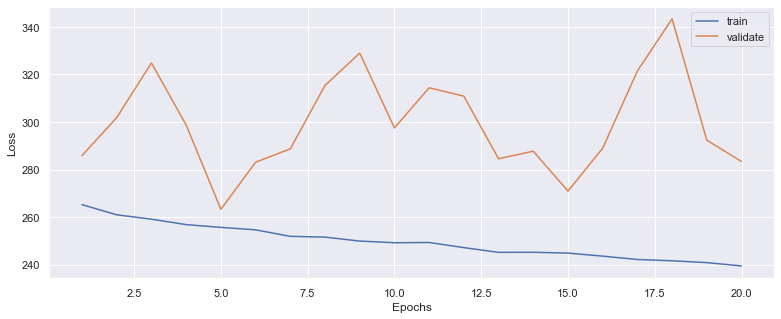

In [44]:
# 모델 예측 (predict) 과 여태까지 한 모든 전처리 도입!
X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1)) # 작동 조건 적용
X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors) # 조건 기반 스케일

X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, 0.4) # 지수 이동 평균
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, 0.4)

X_train_interim = add_specific_lags(X_train_interim, specific_lags, remaining_sensors) # 지연 변수 적용
X_test_interim = add_specific_lags(X_test_interim, specific_lags, remaining_sensors)

X_train_smooth_lagged = X_train_interim.drop(index_names+setting_names+['op_cond', 'RUL'], axis=1) 
X_test_smooth_lagged = X_test_interim.drop(['time_cycles', 'op_cond']+setting_names, 
                                      axis=1).groupby('unit_nr').last().copy()

idx = X_train_smooth_lagged.index 
y_train_clipped_lagged = y_train_clipped.iloc[idx]

# train-val split
split_result = train_val_group_split(X_train_smooth_lagged, y_train_clipped_lagged, gss, train.iloc[idx]['unit_nr'], print_groups=False)
X_train_split_smooth_lagged, y_train_clipped_split_lagged = split_result[:2]
X_val_split_smooth_lagged, y_val_clipped_split_lagged = split_result[2:]

history = model.fit(X_train_split_smooth_lagged, y_train_clipped_split_lagged,
                    validation_data=(X_val_split_smooth_lagged, y_val_clipped_split_lagged),
                    epochs=epochs)

plot_loss(history)

In [45]:
# predict and evaluate
y_hat_train = model.predict(X_train_smooth_lagged)
evaluate(y_train_clipped_lagged, y_hat_train, 'train')

y_hat_test = model.predict(X_test_smooth_lagged)
evaluate(y_test, y_hat_test)

train set RMSE:15.549273529776535, R2:0.8618925772368967
test set RMSE:28.11081387247473, R2:0.7267723048621827


test RMSE 27.85로 상당히 줄었다.  여기서 동일한 모델을 써서  
유효성 검사 손실 작동을 확인하기 위해 epoch를 크랭크해보자.
더 많은 epoch에 대해 일정하게 유지된다면 튜닝에서 더 많은 epoch을 사용할 수 있음을 의미한다.

In [47]:
model.compile(loss='mean_squared_error', optimizer='adam')
# model.load_weights('specific_lagged_weights.h5')
epochs=50  # 20에서 50으로 더 늘려보았다.

# X_train_array = X_train_split_condition_scaled_lagged.values
# y_train_array = y_train_clipped_split_lagged.values

# X_val_array = X_val_split_condition_scaled_lagged.values
# y_val_array = y_val_clipped_split_lagged.values

history = model.fit(X_train_split_smooth_lagged, y_train_clipped_split_lagged,
                    validation_data=(X_val_split_smooth_lagged, y_val_clipped_split_lagged),
#                     callbacks=[callback],
                    epochs=epochs)

Epoch 1/50
1229/1229 [==============================] - 2s 2ms/step - loss: 239.1471 - val_loss: 278.4504
Epoch 2/50
1229/1229 [==============================] - 2s 1ms/step - loss: 238.9791 - val_loss: 289.8593
Epoch 3/50
1229/1229 [==============================] - 2s 1ms/step - loss: 237.0279 - val_loss: 295.4530
Epoch 4/50
1229/1229 [==============================] - 2s 1ms/step - loss: 237.1310 - val_loss: 300.4982
Epoch 5/50
1229/1229 [==============================] - 2s 2ms/step - loss: 235.6888 - val_loss: 302.7261
Epoch 6/50
1229/1229 [==============================] - 2s 2ms/step - loss: 235.4846 - val_loss: 344.9958
Epoch 7/50
1229/1229 [==============================] - 2s 2ms/step - loss: 234.4905 - val_loss: 306.3162
Epoch 8/50
1229/1229 [==============================] - 3s 2ms/step - loss: 233.9174 - val_loss: 288.3451
Epoch 9/50
1229/1229 [==============================] - 3s 2ms/step - loss: 233.7078 - val_loss: 306.0862
Epoch 10/50
1229/1229 [=======================

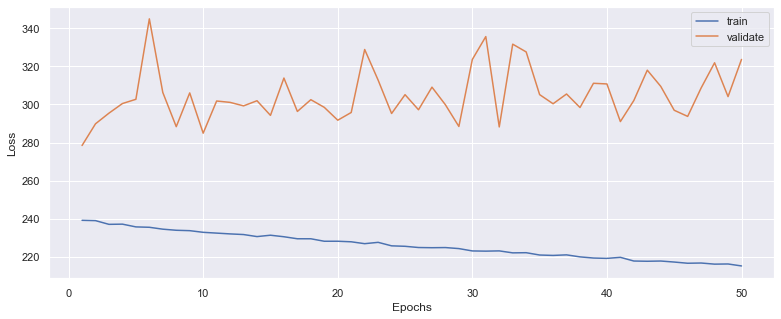

In [48]:
plot_loss(history)

In [49]:
# predict and evaluate
y_hat_train = model.predict(X_train_condition_scaled_lagged)
evaluate(y_train_clipped_lagged, y_hat_train, 'train')

y_hat_test = model.predict(X_test_condition_scaled_lagged)
evaluate(y_test, y_hat_test)

train set RMSE:20.007729791901266, R2:0.7713388195108959
test set RMSE:31.281929621918813, R2:0.6616509600135649


오히려 RMSE가 크게 증가하였다.  
Overfitting을 방지하기 위해 드롭아웃을 추가하고, 10~30 epoch 사이에서 진행하는 게 좋다!

### 하이퍼파라미터 조정
하이퍼파라미터는 여러 개 존재하지만, 아래 항목은 모델의 복잡성을 줄이기 위해 건들지 않기로 했다.  

- 알파: 지수 평활 평균 필터의 강도
- 시차: 행에 추가할 이전 시간 단계. 이 매개변수를 조정하지 않기로 선택.
- Epochs: 데이터가 NN에 공급되는 횟수. 더 많은 에포크는 더 나은 학습을 허용하지만 과적합의 가능성 O.
- NN의 레이어 수, 이 매개변수를 조정하지 않기로 선택.
- 계층당 노드 수: 각 계층의 노드 수
- 드롭아웃: 0으로 설정되는 레이어의 노드 출력 비율, 일부 노드를 쓰지 않고 학습  
드롭아웃은 과적합을 방지하는 데 도움이 된다.
- 옵티마이저 및 학습률:  이 매개변수를 조정하지 않기로 선택
- 활성화 함수(activation function): 활성화 함수는 계층 출력의 후처리 형태로 간주된다.   
예를 들어, relu 활성화는 모든 음수 출력을 0으로 설정.
- 배치 크기: 가중치를 업데이트하기 전에 네트워크에 공급된 샘플 수

In [50]:
# earlier testing revealed lower alpha's perform better, so we can ditch a few high ones to reduce the search space
# 여러 가능한 하이퍼파라미터의 조합을 테스트해보자.
alpha_list = [0.01, 0.05] + list(np.arange(10,60+1,10)/100)
epoch_list = list(np.arange(10,30+1,5))
nodes_list = [[16, 32, 64], [32, 64, 128], [64, 128, 256], [128, 256, 512]]

# lowest dropout=0.1, because I know zero dropout will yield better training results but worse generalization (overfitting)
dropouts = list(np.arange(1,5)/10)  

# earlier testing revealed relu performed significantly worse, so I removed it from the options
activation_functions = ['tanh', 'sigmoid']  
batch_size_list = [32, 64, 128, 256, 512]

tuning_options = np.prod([len(alpha_list),
                          len(epoch_list),
                          len(nodes_list),
                          len(dropouts),
                          len(activation_functions),
                          len(batch_size_list)])
tuning_options  # returns 6400

6400

In [51]:
# 아까 했던 모든 데이터 전처리를 적용.
def prep_data(df_train, train_label, df_test, remaining_sensors, lags, alpha, n=0):
    X_train_interim = add_operating_condition(df_train)
    X_test_interim = add_operating_condition(df_test)

    X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

    X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, n, alpha)
    X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, n, alpha)

    X_train_interim = add_specific_lags(X_train_interim, lags, remaining_sensors)
    X_test_interim = add_specific_lags(X_test_interim, lags, remaining_sensors)

    X_train_interim.drop(index_names+setting_names+['op_cond', 'RUL'], axis=1, inplace=True)
    X_test_interim = X_test_interim.drop(
        ['time_cycles', 'op_cond']+setting_names, axis=1).groupby('unit_nr').last().copy()

    idx = X_train_interim.index
    train_label = train_label.iloc[idx]
    return X_train_interim, train_label, X_test_interim, idx

In [53]:
# NN 모델 정의
def create_model(input_dim, nodes_per_layer, dropout, activation, weights_file):
    model = Sequential()
    model.add(Dense(nodes_per_layer[0], input_dim=input_dim, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(nodes_per_layer[1], activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(nodes_per_layer[2], activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.save_weights(weights_file)
    return model

In [54]:
# trainer 정의
ITERATIONS = 100 

results = pd.DataFrame(columns=['MSE', 'std_MSE', # bigger std means less robust
                                'alpha', 'epochs', 
                                'nodes', 'dropout', 
                                'activation', 'batch_size'])  
weights_file = 'mlp_hyper_parameter_weights.h5'
specific_lags = [1,2,3,4,5,10,20]

for i in range(ITERATIONS):
    if ITERATIONS < 10:
        print('iteration ', i+1)
    elif ((i+1) % 10 == 0):
        print('iteration ', i+1)
    
    mse = []
    
    # init parameters
    alpha = random.sample(alpha_list, 1)[0]
    epochs = random.sample(epoch_list, 1)[0]
    nodes_per_layer = random.sample(nodes_list, 1)[0]
    dropout = random.sample(dropouts, 1)[0]
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_size_list, 1)[0]
    
    # create dataset
    df_train, train_label, _, idx = prep_data(df_train=train.drop(drop_sensors, axis=1),
                                            train_label=y_train_clipped,
                                            df_test=test.drop(drop_sensors, axis=1), 
                                            remaining_sensors=remaining_sensors,
                                            lags=specific_lags, 
                                            alpha=alpha)
    
    # create model
    input_dim = len(df_train.columns)
    model = create_model(input_dim, nodes_per_layer, dropout, activation, weights_file)
    
    
    # create train-validation split
    gss_search = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
    for idx_train, idx_val in gss_search.split(df_train, train_label, groups=train.iloc[idx]['unit_nr']):
        X_train_split = df_train.iloc[idx_train].copy()
        y_train_split = train_label.iloc[idx_train].copy()
        X_val_split = df_train.iloc[idx_val].copy()
        y_val_split = train_label.iloc[idx_val].copy()
        
        # train and evaluate model
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(X_train_split, y_train_split,
                            validation_data=(X_val_split, y_val_split),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)
        
        mse.append(history.history['val_loss'][-1])
    
    
    # append results
    d = {'MSE':np.mean(mse), 'std_MSE':np.std(mse), 'alpha':alpha, 
         'epochs':epochs, 'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size}
    results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)

iteration  10
iteration  20
iteration  30
iteration  40
iteration  50
iteration  60
iteration  70
iteration  80
iteration  90
iteration  100


In [55]:
results

MSE    std_MSE  alpha epochs            nodes  dropout activation  \
0   298.084778  15.275255   0.40     20    [32, 64, 128]      0.3       tanh   
1   289.715210  23.049973   0.60     25   [64, 128, 256]      0.4    sigmoid   
2   269.248362  21.556938   0.40     10  [128, 256, 512]      0.3    sigmoid   
3   194.990097   7.780848   0.05     10    [32, 64, 128]      0.2    sigmoid   
4   302.502319  23.064164   0.60     30     [16, 32, 64]      0.4       tanh   
..         ...        ...    ...    ...              ...      ...        ...   
95  197.639618   7.711987   0.10     15    [32, 64, 128]      0.1    sigmoid   
96  287.296926  24.795550   0.50     20    [32, 64, 128]      0.4    sigmoid   
97  228.904836  14.570667   0.20     30   [64, 128, 256]      0.2       tanh   
98  212.355596  21.911320   0.10     20     [16, 32, 64]      0.1       tanh   
99  282.944295  30.184655   0.50     20  [128, 256, 512]      0.3    sigmoid   

   batch_size  
0         512  
1          32  
2         128  
3         128  
4          64  
..        ...  
95         32  
96         32  
97        256  
98         32  
99         64  

[100 rows x 8 columns]

In [57]:
results.sort_values(by=['MSE','std_MSE'],ascending=True)
# a = 0.05, epochs=10, dropout=0.2 activation=tanh, batch_size=128일 때 가장 MSE가 낮다.

MSE     std_MSE  alpha epochs            nodes  dropout  \
45   173.201767    8.291658   0.05     10  [128, 256, 512]      0.2   
8    174.329091    6.402477   0.05     20   [64, 128, 256]      0.3   
20   178.812307    5.861620   0.05     25     [16, 32, 64]      0.1   
71   179.059372   11.955837   0.05     10  [128, 256, 512]      0.3   
84   179.633575   11.492846   0.05     25   [64, 128, 256]      0.4   
..          ...         ...    ...    ...              ...      ...   
6   1908.993286   86.836191   0.30     10     [16, 32, 64]      0.1   
74  1968.397990   71.867446   0.20     10    [32, 64, 128]      0.4   
85  2332.894694   88.779163   0.05     15     [16, 32, 64]      0.4   
81  2834.293050  117.603941   0.10     15     [16, 32, 64]      0.1   
72  3734.822835  147.894900   0.30     10     [16, 32, 64]      0.1   

   activation batch_size  
45       tanh        128  
8        tanh        512  
20       tanh        256  
71    sigmoid        128  
84    sigmoid        128  
..        ...        ...  
6     sigmoid        256  
74    sigmoid        512  
85    sigmoid        512  
81    sigmoid        512  
72    sigmoid        512  

[100 rows x 8 columns]

In [58]:
# 최적의 파라미터 - 최종 모델
alpha = 0.05
epochs = 10 
specific_lags = [1,2,3,4,5,10,20]
nodes = [64, 128, 256]
dropout = 0.2
activation = 'tanh'
batch_size = 64


df_train, train_label, df_test, _ = prep_data(df_train=train.drop(drop_sensors, axis=1),
                                        train_label=y_train_clipped,
                                        df_test=test.drop(drop_sensors, axis=1), 
                                        remaining_sensors=remaining_sensors,
                                        lags=specific_lags, 
                                        alpha=alpha)

input_dim = len(df_train.columns)
weights_file = 'fd002_model_weights.h5'
final_model = create_model(input_dim, 
                           nodes_per_layer=nodes, 
                           dropout=dropout, 
                           activation=activation, 
                           weights_file=weights_file)

final_model.compile(loss='mean_squared_error', optimizer='adam')
final_model.load_weights(weights_file)

final_model.fit(df_train, train_label,
               epochs=epochs,
               batch_size=batch_size)

# predict and evaluate
y_hat_train = final_model.predict(df_train)
evaluate(train_label, y_hat_train, 'train')

y_hat_test = final_model.predict(df_test)
evaluate(y_test, y_hat_test)

Epoch 1/10
759/759 [==============================] - 5s 6ms/step - loss: 1435.8882
Epoch 2/10
759/759 [==============================] - 5s 7ms/step - loss: 220.3248
Epoch 3/10
759/759 [==============================] - 5s 7ms/step - loss: 205.7163
Epoch 4/10
759/759 [==============================] - 5s 6ms/step - loss: 202.0038
Epoch 5/10
759/759 [==============================] - 5s 6ms/step - loss: 200.2055
Epoch 6/10
759/759 [==============================] - 5s 6ms/step - loss: 197.6894
Epoch 7/10
759/759 [==============================] - 5s 7ms/step - loss: 193.7647
Epoch 8/10
759/759 [==============================] - 5s 7ms/step - loss: 194.3800
Epoch 9/10
759/759 [==============================] - 5s 6ms/step - loss: 192.9393
Epoch 10/10
759/759 [==============================] - 5s 6ms/step - loss: 191.9419
train set RMSE:13.42533780458115, R2:0.897045043747746
test set RMSE:24.90568024360763, R2:0.7855259783591597


기존 MLP에서 최적의 하이퍼파라미터 적용, 지연, 조건 기반 스케일러 등 여러 최적화 기법을 적용한 결과  
기본적인 NN을 사용했을 때에 비해 RMSE가 24로 매우 감소한 것을 확인할 수 있었다!